In [24]:
import json
import numpy as np
import torch
from src.gan.generators_spde import Generator
from src.gan.base import stopping_criterion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy import stats as st
from statsmodels.tsa.stattools import acf
from src.evaluation_functions import generate_ks_results_nspde
import matplotlib as mpl
import scienceplots

In [26]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

In [27]:
def my_smooth_corr(x, a, r = 2):
    my_eps=0.001
    j = 1.*torch.arange(1,x.shape[0]+1).to(x.device)
    j[-1] = 0.
    q = j**(-(2*r+1+my_eps)/2)
    q[-1]=0
    res = torch.sqrt(q)*torch.sqrt(2. / a) * torch.sin(j * torch.pi * x / a)
    return res

In [28]:
data = np.load('../../data/lob_neurips.npy')
data =  torch.tensor(data)

dim_x = 20
dim_t = 32
output_dim = 1

gridT = torch.linspace(0,1,dim_t).repeat(dim_x,1)
gridX = torch.linspace(0,1,dim_x).unsqueeze(-1).repeat(1,dim_t)
grid = torch.stack([gridX, gridT], dim=-1)

In [38]:
discriminators = ['rbf_id/', 'rbf_sqr/', 'rbf_cexp/']

base_path = "../../scripts/results/"

eval_batch_size = 128
dataloader = torch.utils.data.DataLoader(data, batch_size=eval_batch_size, shuffle=True)
infinite_train_dataloader = (elem for it in iter(lambda: dataloader, None) for elem in it)

marginals = tuple([i*1./30 for i in range(30)])
alpha     = 0.95
tol       = 1 - alpha
n_runs    = 100
print(marginals[-1])



results_ks = []
for dis, discriminator in enumerate(discriminators):
    best_run_ks = 0
    best_run_id = 0

    for i in range(1,233):
        file = base_path + discriminator + str(i) + "/metrics.json"
        res = 0
        try:
            with open(file, 'r') as f:
                res = json.load(f)["best_ks"]["values"][0]
        except:
            pass
        if res > best_run_ks and res<0.72:
            best_run_ks = res
            best_run_id = i
    
    file = base_path + discriminator + str(best_run_id) + "/config.json"
    with open(file, 'r') as f:
        config = json.load(f)
        print(config)
        # create correlation function for the noise in input to the generator
        if config['generator__noise_type'][0] == 'r':
            input_roughness = int(config['generator__noise_type'].split('_')[-1])
            generator_correlation = lambda x,a : my_smooth_corr(x, a, r = input_roughness)
            config['generator__noise_type'] = generator_correlation
        else:
            pass
        print(config)
        
    generator = Generator(
    dim=config['generator__dim'],
    data_size=config['generator__output_dim'], 
    initial_noise_size=config['generator__initial_noise_size'],
    noise_size=config['generator__noise_size'], 
    hidden_size=config['generator__hidden_size'], 
    initial_point='given',
    noise_type=config['generator__noise_type'],
    integration_method=config['generator__integration_method'],
    modes1=config['generator__modes1'], 
    modes2=config['generator__modes2'],).cuda()

    generator.load_state_dict(torch.load(base_path+discriminator+str(best_run_id)+'/generator_checkpoint.pt'))
    
    dims = dim_x
    path_length = dim_t
    generators = [generator]

    mean_ks = np.zeros((len(generators), dims, len(marginals)))


    total_ks_results = generate_ks_results_nspde(
        grid.to(device), infinite_train_dataloader, generators, marginals, n_runs, dims=dims, eval_batch_size=eval_batch_size, device=device
    )

    for k in range(dims):
        for i, m in enumerate(marginals):
            for j, disc in enumerate(['ours']):

                average_score  = np.mean(total_ks_results[j, :, k, i, 0])
                std_score      = np.std(total_ks_results[j, :, k, i, 0])
                percent_reject = sum(total_ks_results[j, :, k, i, 1] <= tol)/n_runs

                mean_ks[j,k,i] = average_score

                lci, hci = st.norm.interval(alpha, loc=average_score, scale=std_score)

    results_ks.append(mean_ks[0])
    

0.9666666666666667
{'discriminator__dyadic_order': 1, 'discriminator__kernel_type': 'rbf_id', 'discriminator__max_batch': 32, 'discriminator__sigma': {'sigma': 10}, 'discriminator__transform': 'integrate', 'generator__dim': 1, 'generator__hidden_size': 16, 'generator__initial_noise_size': 1, 'generator__integration_method': 'fixed_point', 'generator__modes1': 20, 'generator__modes2': 20, 'generator__n_iter': 4, 'generator__noise_size': 2, 'generator__noise_type': 'white', 'generator__output_dim': 1, 'seed': 540769236, 'training__batch_size': 64, 'training__lr': 0.001, 'training__steps': 1500, 'training__wd': 0}
{'discriminator__dyadic_order': 1, 'discriminator__kernel_type': 'rbf_id', 'discriminator__max_batch': 32, 'discriminator__sigma': {'sigma': 10}, 'discriminator__transform': 'integrate', 'generator__dim': 1, 'generator__hidden_size': 16, 'generator__initial_noise_size': 1, 'generator__integration_method': 'fixed_point', 'generator__modes1': 20, 'generator__modes2': 20, 'generato

In [33]:
plt.style.use('science')
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 22

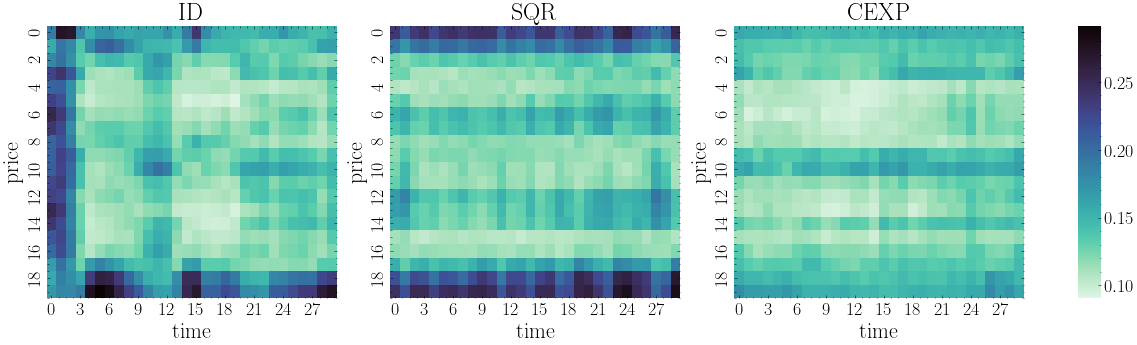

In [35]:
fig, (ax1,ax2,ax3, axcb) = plt.subplots(1,4,figsize=(16,5), gridspec_kw={'width_ratios':[1,1,1,0.08]})
ax1.get_shared_y_axes().join(ax2,ax3)
cmap = sns.color_palette("mako_r", as_cmap=True) 
vmin = np.min([np.min(results_ks[0]),np.min(results_ks[1]),np.min(results_ks[2])])
vmax = np.max([np.max(results_ks[0]),np.max(results_ks[1]),np.max(results_ks[2])])

for i in range(3):
    if i==0:
        sns.heatmap(results_ks[i],ax = ax1,cbar=False,vmin=vmin, vmax=vmax, cmap=cmap)
        ax1.set_xlabel('time')
        ax1.set_ylabel('price')
        ax1.set_title('ID')
    elif i==1:
        sns.heatmap(results_ks[i],ax=ax2,cbar=False,vmin=vmin, vmax=vmax, cmap=cmap)
        ax2.set_xlabel('time')
        ax2.set_ylabel('price')
        ax2.set_title('SQR')
    else:
        sns.heatmap(results_ks[i],ax=ax3, cbar_ax=axcb, vmin=vmin, vmax=vmax, cmap=cmap)
        ax3.set_xlabel('time')
        ax3.set_ylabel('price')
        ax3.set_title('CEXP')
plt.tight_layout()
plt.savefig('lob.png',dpi=1000)
plt.show()